# The Minimum Set Cover Problem

## Introduction and Problem Statement

The set cover problem, also referred to as the minimum set cover problem, concerns a finite "universe" set $U = \{u_1,\dots u_m\}$ and some subsets $S_1 \dots S_n \subset U$ such that $\bigcup_{i=1}^n S_i = U$.  
Each set may have an associated cost $c_1 \dots c_n$.
The task is to choose the minimum cost set cover: a collection of $S_i$ such that their union is $U$ and their total cost is minimal.  
(This problem may be expressed in various ways, e.g. compare Chvatal (1979) and Zhou et al. (2014)).  
This problem is known to be NP-complete.

Wireless network coverage is a common application for the minimum set cover problem and its many variants.  
Many other applications exist. For example, Algador and Cerdeira (2020) apply it to protected conservation areas, with the objective being to protect habitat for as many species as possible at the minimum cost.  
Many algorithms and computational methods exist. For example, Zhou et al. (2014) apply DNA computing to solve the problem.  

Here, we focus only on the most basic formulation of the problem, and compare solutions by integer programming, a greedy algorithm, and brute force.

## Expressing as an Integer Programming Problem

It is relatively straightforward to phrase this as a integer programming problem:
* We set up the problem with $m$ elements of $U$ and $n$ different sets.
* The decision variables are $x_i$ such that $x_i = 1$ if set $S_i$ is part of the set cover, and 0 otherwise.
* The constraint matrix $C$ is a $n \times m$ matrix defined by $C_{ij} = 1$ if the element $u_j \in U$ is included in set $S_i$, and 0 otherwise.
* The constraints are that each element of $U$ must be included in the set cover:
$$
\sum_i C_{ij}x_i \ge 1, \text{for each } j = 0, \dots m-1
$$
* The cost vector has elements $c_1 \dots c_n$, with $c_i$ being the cost for set $S_i$.
* The objective function is $\min \sum_{i=1}^n c_ix_i$.

## Example

We generate some artificial data to demonstrate various methods of solving.  
For simplicity, we set all the costs to be 1.

In [104]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import copy
from itertools import combinations

In [71]:
m = 100 # number of elements
n = 20 # number of sets

# generate random dataset
# this code referenced from lecture on Feb 14
C = np.zeros((n,m))
for i in range(n):
    # using seeded values for replicability
    generator = np.random.default_rng(seed=i*2)
    setsize = generator.integers(1,m) # sets of size at least 1, at most m-1
    js = generator.choice(range(m),size=setsize,replace=False) # choose set elements
    C[i,js] = 1.

# ensure every element is in at least one set
for j in range(m):
    if np.sum(C[:,j]) < 1:
        randidx = np.random.randint(n)
        C[randidx,j] = 1.

print(np.sum(C,axis=0)) # number of sets each element is in

[12.  8. 12. 10. 12. 10. 12. 12. 14. 11. 10. 14. 12. 10. 12. 11. 10. 14.
 13. 14.  7. 11. 10. 15. 11. 12. 13. 13. 12. 10. 14. 11. 13. 10. 13. 12.
 11. 14. 13. 12. 14. 11. 10. 11. 12. 13. 13. 11. 13. 11. 11. 14. 13. 10.
 12. 12. 11.  9.  7. 14. 14.  9.  9. 14.  9. 13. 14. 13. 14.  7. 11. 13.
 13. 12. 11. 11. 12. 13. 12. 10. 14. 12. 14. 15. 14. 10.  9. 10. 12. 12.
 11. 11. 13. 11. 11. 11. 15. 12. 10. 14.]


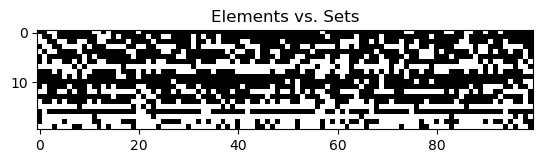

In [72]:
plt.imshow(C,cmap='binary'), plt.title("Elements vs. Sets")
plt.show()

In [144]:
# set up the optimization problem

x = cp.Variable(shape=n,integer=True)

cost = np.ones(n) # for simplicity, we set all costs to be 1

# define objective
objective = cp.Minimize(cp.sum(cp.multiply(cost[i],x[i])))

# define constraint
constraint1 = []
for j in range(m):
    constraint1 += [cp.sum(cp.multiply(C[:,j],x)) >= 1]
constraint2 = [x[i] >= 0 for i in range(n)]

constraints = constraint1 + constraint2
problem = cp.Problem(objective,constraints)

In [145]:
problem.solve()

0.0

In [146]:
problem.status

'optimal'

In [147]:
x.value

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0.])

An optimal solution is found, giving a cover consisting of a couple sets.

In [148]:
C.T@x.value

array([2., 2., 3., 1., 2., 1., 3., 1., 3., 1., 2., 3., 1., 2., 3., 3., 2.,
       2., 3., 2., 1., 2., 2., 3., 1., 2., 3., 3., 2., 3., 3., 3., 2., 2.,
       3., 3., 2., 1., 2., 2., 2., 3., 2., 2., 3., 2., 3., 1., 3., 2., 2.,
       2., 2., 2., 2., 1., 1., 1., 1., 2., 2., 1., 2., 2., 2., 1., 3., 2.,
       3., 1., 2., 2., 3., 2., 2., 3., 3., 3., 2., 3., 3., 3., 3., 3., 2.,
       2., 2., 2., 2., 3., 2., 3., 1., 2., 2., 2., 3., 2., 2., 2.])

$C^Tx$ gives the number of sets in the cover that contain each element.  
We can verify that every element is represented at least once in the cover.

## Approximation: Greedy Algorithm

Chvatal (1979) describes a natural greedy algorithm, reproduced below (using the notation defined above): 
1. Start with $J^* = \emptyset$.
2. If all subsets are empty, stop: we have found a cover.
3. Otherwise, find some $k$ such that the ratio $|S_k| / c_k$ is minimal, where $c_k$ is the cost of $S_k$.
4. Add $k$ to $J^*$ and replace every subset $S_i$ with $S_i - S_k$. Return to step 2.

Chvatal claims that this algorithm returns a result with cost at most $\sum_{j=1}^d \frac{1}{j}$ times the optimal cost, where $d = \max_i |S_i|$ is the size of the largest subset.   

We attempt to implement Chvatal's algorithm below.

In [149]:
def checkallzero(A): # return true if all elements of matrix A are zero
    return np.all(A == np.zeros(A.shape))

def greedysetcover(C,cost):
    A = copy.deepcopy(C) # avoid directly modifying the actual set, for replicability
    n,m = A.shape
    cover = np.zeros(n) # selected subsets
    # run the greedy algorithm
    for _ in range(n): #can't loop more than n times
        if (checkallzero(A)): 
            break
        sizes = np.sum(A,axis=1) # vector of sizes of every element
        size_to_cost = sizes / cost
        k = np.argmax(size_to_cost)
        cover[k] = 1
        # for every element in set k, set that column to 0
        for j in range(m):
            if A[k,j] == 1:
                A[:,j] = np.zeros(n)
    return cover

In [136]:
%%timeit
greedysetcover(C,cost)

217 µs ± 18.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In this case, the greedy algorithm was able to find the optimal solution.

### Comparison with Brute Force  

We can compare the runtime of the greedy algorithm to that of the brute force method of checking every possible combination.

In [127]:
def checksetcoverage(A, comb):
    coverelements = A[comb,:]
    return np.all(np.sum(coverelements,axis=0) >= np.ones(A.shape[1]))

# calculate the cost of some combination of rows
def combcost(A,comb,cost):
    selection = np.zeros(A.shape[0])
    for i in comb:
        selection[i] = 1
    return cost.T @ selection

In [140]:
def bruteforcesetcover(C,cost):
    n,m = C.shape
    mincost = np.inf
    mincomb = (-1,-1) # placeholder value
    
    for k in range(2,n):
        for comb in combinations(range(n),k):
            # check if combination covers all data points
            if checksetcoverage(C,comb):
                combinationcost = combcost(C,comb,cost)
                if combinationcost < mincost:
                    mincost = combinationcost
                    mincomb = comb
    if mincost == np.inf: # no combination covered all elements
        return np.ones(n) # all elements guaranteed to cover all elements
    else:
        return mincomb

In [142]:
%%timeit
bruteforcesetcover(C,cost)

30 s ± 557 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Clearly, the greedy algorithm is much faster than the brute force method.  
In the worst case, the greedy algorithm needs $n$ iterations, while the brute force method requires checking $2^n$ combinations - as $n$ becomes large, the greedy algorithm becomes far faster.

## References

Alagador, Diogo, and Jorge Orestes Cerdeira. "Revisiting the minimum set cover, the maximal coverage problems and a maximum benefit area selection problem to make climate-change-concerned conservation plans effective". *Methods in Ecology and Evolution*, vol. 11, no. 10, October 2020, pp. 1325-1337. https://doi.org/10.1111/2041-210X.13455.

Chvátal, Václav. "A Greedy Heuristic for the Set-Covering Problem". *Mathematics of Operational Research*, vol. 4, no. 3, August 1979, pp. 233-235. *JSTOR*, https://www.jstor.org/stable/3689577.  

"Set Cover Problem". *Wikipedia*, Wikimedia Foundation, https://en.wikipedia.org/wiki/Set_cover_problem. Accessed 8 Mar 2024.

Zhou, Xu et al. "Molecular solutions for minimum and exact cover problems in the tile assembly model". *The Journal of Supercomputing*, vol. 69, August 2014, pp. 976–1005. https://doi.org/10.1007/s11227-014-1222-x.